# Importing

Importing the necessary libraries

In [203]:
import os
import pandas as pd
import numpy as np

import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Data Processing

In [204]:
directory = "/Users/vbraun/Downloads/training_set/"

Code to append movieId to each record in all of the source files if this has not been executed earlier. This will allow all the source files to be loaded into a dataframe with one line of code and without having to add the movieId seperately before concatting the sourcefiles.

In [205]:
def movieId_to_source():
    x = 0
    string = ","+str(x)
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as f:
            if(f.readlines()[0] == '1:,1\n'):
                print('Already formatted, continuing')
                return
            else:
                file_lines = [''.join([x.strip(), string, '\n']) for x in f.readlines()]
        with open(os.path.join(directory, filename), 'w') as f:
            f.writelines(file_lines)
    return

In [206]:
movieId_to_source()

Already formatted, continuing


Creating the movie dataframe by concatting all the sourcefiles without their title (skiprows=1). Concluding with naming the columns.

In [207]:
movie_df = pd.concat(pd.read_csv(os.path.join(directory, fname), skiprows=1,header=None) for fname in os.listdir(directory)).rename(columns={0:'userId',1:'rating',2:'date',3:'itemId'})

display(movie_df.head(5))

,userId,rating,date,itemId
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


Dropping the date column as this is not relevant for this RecSys

In [208]:
movie_df = movie_df.drop(columns='date')

### Data filtering

To allow for faster development a debugging variable is used. If debugging is True the dataset will only consist of the first 100 movies. For the final model, debugging will be set to False.

In [209]:
debugging = True

In [210]:
if debugging == True:
    filtered_movie_df = movie_df[movie_df['itemId'] <= 100]
else:
    filtered_movie_df = movie_df
print('Length of dataset:',len(filtered_movie_df))

Length of dataset: 352771


In order to filter the dataset based on activity and reduce the sparsity of the data, the data will be grouped and filtered based on movies and users. The datasets will show how many ratings each movie has gotten and how many rating each user has given.

In [211]:
filtered_movie_count = filtered_movie_df[['itemId','userId']].groupby('itemId').count().reset_index().rename(columns={'userId':'user_count'})
filtered_user_count = filtered_movie_df[['itemId','userId']].groupby('userId').count().reset_index().rename(columns={'itemId':'item_count'})

display(filtered_movie_count.head(3),filtered_user_count.head(3))

,itemId,user_count
0,1,547
1,2,145
2,3,2012


,userId,item_count
0,6,1
1,7,4
2,42,1


To reduce the sparcity of data in the dataset, we will filter out the users that have rated fewer than 5% of the total amount of movies.

In [212]:
filtered_movie_df = filtered_movie_df[filtered_movie_df['userId'].isin(filtered_user_count[filtered_user_count['item_count']/len(filtered_movie_count) > 0.05]['userId'])]

print('Length of dataset:',len(filtered_movie_df))

Length of dataset: 44209


Finally, the movies that have been rated by fewer than 50 people will be filtered out of the dataset.

In [213]:
filtered_movie_df = filtered_movie_df[filtered_movie_df['itemId'].isin(filtered_movie_count[filtered_movie_count['user_count']>50]['itemId'])]

print('Length of dataset:',len(filtered_movie_df))

Length of dataset: 44209


## Jester

In [382]:
jester_items = pd.read_csv(r'C:\Users\vbraun\Downloads\SDM-Datasets\jester_items.csv')
jester_ratings = pd.read_csv(r'C:\Users\vbraun\Downloads\SDM-Datasets\jester_ratings.csv')
jester_df = jester_ratings.rename(columns={'jokeId':'itemId'})
jester_df['rating'] = jester_df['rating'] + 10
jester_item_count = jester_df[['itemId','userId']].groupby('itemId').count().reset_index().rename(columns={'userId':'user_count'})
jester_user_count = jester_df[['itemId','userId']].groupby('userId').count().reset_index().rename(columns={'itemId':'item_count'})
filtered_jester_df = jester_df[jester_df['userId'].isin(jester_user_count[jester_user_count['item_count']/len(jester_item_count) > 0.05]['userId'])]
filtered_jester_df = filtered_jester_df[filtered_jester_df['itemId'].isin(jester_item_count[jester_item_count['user_count']>20]['itemId'])]

## Dataset Selection

In [383]:
is_movie_dataset = False

if is_movie_dataset == True:
    filtered_df = filtered_movie_df
else:
    filtered_df = filtered_jester_df

# EDA

In [384]:
print('The filtered dataset has', filtered_df['userId'].nunique(), 'unique users')
print('The filtered dataset has', filtered_df['itemId'].nunique(), 'unique movies')
print('The filtered dataset has', filtered_df['rating'].nunique(), 'unique ratings')
print('The unique ratings are', sorted(filtered_df['rating'].unique()))

The filtered dataset has 50712 unique users
The filtered dataset has 140 unique movies
The filtered dataset has 641 unique ratings
The unique ratings are [0.0, 0.031000000000000583, 0.06199999999999939, 0.09399999999999942, 0.125, 0.15600000000000058, 0.1880000000000006, 0.21899999999999942, 0.25, 0.2810000000000006, 0.3119999999999994, 0.3439999999999994, 0.375, 0.4060000000000006, 0.4380000000000006, 0.4689999999999994, 0.5, 0.5310000000000006, 0.5619999999999994, 0.5939999999999994, 0.625, 0.6560000000000006, 0.6880000000000006, 0.7189999999999994, 0.75, 0.7810000000000006, 0.8119999999999994, 0.8439999999999994, 0.875, 0.9060000000000006, 0.9380000000000006, 0.9689999999999994, 1.0, 1.0310000000000006, 1.0620000000000012, 1.0939999999999994, 1.125, 1.1560000000000006, 1.1879999999999988, 1.2189999999999994, 1.25, 1.2810000000000006, 1.3120000000000012, 1.3439999999999994, 1.375, 1.4060000000000006, 1.4379999999999988, 1.4689999999999994, 1.5, 1.5310000000000006, 1.5620000000000012,

In [385]:
display(filtered_df.head(),filtered_df.tail())

,userId,itemId,rating
0,1,5,10.219
1,1,7,0.719
2,1,8,0.719
3,1,13,3.219
4,1,15,10.875


,userId,itemId,rating
1761434,63978,57,1.469
1761435,63978,24,0.938
1761436,63978,124,0.969
1761437,63978,58,1.344
1761438,63978,44,1.562


In [386]:
filtered_df.describe()

,userId,itemId,rating
count,1.729140e+06,1.729140e+06,1.729140e+06
mean,3.275722e+04,7.181966e+01,1.165693e+01
std,1.824293e+04,4.570535e+01,5.270464e+00
min,1.000000e+00,5.000000e+00,0.000000e+00
25%,1.734500e+04,2.300000e+01,8.062000e+00
50%,3.488200e+04,7.000000e+01,1.225000e+01
75%,4.724700e+04,1.130000e+02,1.571900e+01
max,6.397800e+04,1.500000e+02,2.000000e+01


In [387]:
print('Amount of NaN values in the dataset:',filtered_df.loc[lambda x: x.isnull().any(axis=1)].shape[0])

Amount of NaN values in the dataset: 0


The following graph shows for each movie (as a dot) what its mean rating is in comparison to the total amount of ratings. 

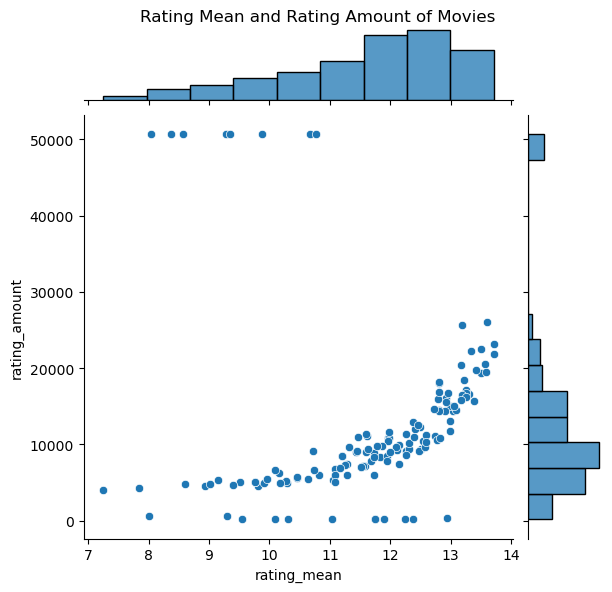

In [388]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_df.groupby('itemId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Movies")
plt.fig.subplots_adjust(top=0.95)

Notably, movies with low mean ratings have generally been rated a low number of times in relation to movies with a mean rating higher than 3.0.

The next graph shows the same variables as the graph seen above for each user. 

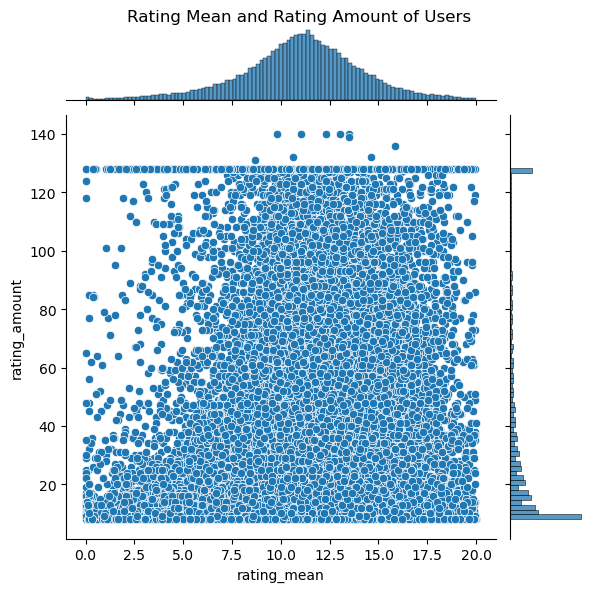

In [389]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_df.groupby('userId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Users")
plt.fig.subplots_adjust(top=0.95)

The graph for users show that there are several outliers of users that have rated many movies while having a low mean of their ratings. Their tendency to rate movies lower in general may have an influence on the mean ratings of those movies. Therefore, in order to reduce this impact the mean rating of a user will subtracted from each rating they have given. This will ensure that the rating shows the positive or negative difference from their base.

# Singular Value Decomposition

Pivot the dataset into a matrix with index='userId', columns='itemId', values='rating' in order to later perform user-based collaborative filtering. Moreover, fill_value = 0 in order to remove NaN values and save them as 0. Finally, the matrix is directly stored as a sparse matrix to save memory, instead of first saving the entire matrix into memory. 

Scipy.sparse.linalg.svds was used to perform a partial singular value decomposition of a sparse matrix. This function allows us to specify 'k' which is the number of singular values and singular vectors that have to be computed. 

In [390]:
def calculate_svd_prediction(data, k = 5):
    # Performing the SVD matrix factorisation giving: u (m x r) orthogonal matrix, 
    # s (r x r) diagonal matrix, and vt(ransposed) (r x n) orthogonal matrix.
    u, s, vt = svds(data.toarray(), k = k)

    # A diagonal matrix has to be created for s in order to recreate a matrix from u, s, and vt
    s_diagonal = np.diag(s)

    # Recreate the matrix by performing matrix multiplications of u, s, and vt
    predictions = np.dot(np.dot(u, s_diagonal), vt)
    
    return predictions

In order to evaluate the performance of the recommendations following SVD we only need the $\hat{y}$ of existing $y$. Therefore, all other values will be filtered out of the prediction dataset by using pred[truth.nonzero()]. Afterwards we are able to evaluate the performance of our model by comparing $\hat{y}$ with their corresponding $y$. 

In [391]:
def evaluate_predictions(pred, truth):
    pred = pred[truth.nonzero()].flatten()
    truth = truth[truth.nonzero()].flatten()

    rmse = np.sqrt(mean_squared_error(pred,truth))
    mae = mean_absolute_error(pred,truth)
    
    return rmse, mae

# Hyper Parameter Tuning

Different k values lead to different predictions

We will perform hyperparameter tuning to find the k with the lowest rmse. For each k we will perform multiple iterations, in which a random sample of the data will be masked and used to calculate the rmse. The rmse of a k value will be the average rmse of all iterations of that k. 

In [396]:
results = []

iterations = 10
print('Calculating the average rmse over {0} iterations'.format(iterations))

k_list = [1,2,3,4,5,6,7,8,9,10,20,30,50,80]

for k in k_list:
    rmse_list = []
    for i in range(0,iterations):
        dataset_ex_masked, masked_data = train_test_split(filtered_df, test_size=.05)

        dataset_ex_masked_csr = csr_matrix(dataset_ex_masked.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
        masked_data_csr = csr_matrix(masked_data.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)

        rmse, mae = evaluate_predictions(hyper_svd(dataset_ex_masked_csr,k),masked_data_csr.toarray())
        
        rmse_list.append(rmse)
   
    results.append([k,(sum(rmse_list)/len(rmse_list))])
    print('For k = {0}, the average rmse = {1}'.format(k,(sum(rmse_list)/len(rmse_list))))

best_parameters = sorted(results, key=lambda x: x[1])[0]
print('The rmse is lowest for k = {0} at = {1}'.format(best_parameters[0],best_parameters[1]))
    

Calculating the average rmse over 10 iterations
For k = 1, the average rmse = 10.200217072953489
For k = 2, the average rmse = 10.182699150199529
For k = 3, the average rmse = 10.277337593583235
For k = 4, the average rmse = 10.321860162243103
For k = 5, the average rmse = 10.358890513371422
For k = 6, the average rmse = 10.384713161782486
For k = 7, the average rmse = 10.42059128364312
For k = 8, the average rmse = 10.438498309685771
For k = 9, the average rmse = 10.452511071687278
For k = 10, the average rmse = 10.483272457685635
For k = 20, the average rmse = 10.640207062204876
For k = 30, the average rmse = 10.802137088078464
For k = 50, the average rmse = 10.975317742266949
For k = 80, the average rmse = 11.09084500416587
The rmse is lowest for k = 2 at = 10.182699150199529


# Recommendation

In [397]:
final_csr_matrix = csr_matrix(filtered_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
predictions = hyper_svd(final_csr_matrix,best_parameters[0])

In [398]:
recommend_for_user = 650

user_pred_df = pd.DataFrame(predictions)
user_sel_pred_df = user_pred_df.loc[recommend_for_user].sort_values(ascending=False)

user_df = pd.DataFrame(final_csr_matrix.toarray())
selected = pd.DataFrame(user_df.loc[recommend_for_user])
rated_movies = selected.loc[~(selected==0).all(axis=1)].index.values.tolist()

recommended_movies = user_sel_pred_df.loc[~user_sel_pred_df.index.isin(rated_movies)]

print('Rated items are:',rated_movies)
print(recommended_movies[:3])

Rated movies are: [1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 18, 27, 31, 38, 39, 42, 46, 49, 51, 58, 61, 77, 78, 80, 84, 86, 99, 113, 120, 122, 123, 125, 126, 127, 129, 130, 131, 132, 134, 137]
103    6.206503
21     5.750057
94     5.614952
Name: 650, dtype: float64
